In [37]:
# 실행결과 경고메시지 출력 제외
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import KMeans, DBSCAN

#!pip install mlxtend
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

matplotlib.rc("font", family="Malgun Gothic")

# 군집분석

아래는 감독자의 직무능력평가 데이터이다.  
2가지(계층, K-평균) 군집분석을 실시하고 결과를 해석하시오.  
- 데이터 : 직무능력평가.CSV(변수: 7개, 자료 수: 30개)

## 1. 데이터 구성하기

In [2]:
df_raw=pd.read_csv("../data/직무능력평가.csv", engine="python")
df_raw.head()

,EVAL,DISSATIS,PRIVILEGE,CHANCE,ADVANCE,CRITISM,PROMOTION
0,43,51,30,39,61,92,45
1,63,64,51,54,63,73,47
2,71,70,68,69,76,86,48
3,61,63,45,47,54,84,35
4,81,78,56,66,71,83,47


In [3]:
df_raw.isnull().sum() # 결측치 없음

EVAL         0
DISSATIS     0
PRIVILEGE    0
CHANCE       0
ADVANCE      0
CRITISM      0
PROMOTION    0
dtype: int64

In [4]:
# 데이터 표준화
scaler=StandardScaler()
df_raw_scaled=scaler.fit_transform(df_raw)
df_raw_scaled[:5]

array([[-1.8076031 , -1.19166169, -1.92300586, -1.50494461, -0.35542617,
         1.77141034,  0.20430138],
       [-0.13647543, -0.19861028, -0.17733772, -0.20508842, -0.15977874,
        -0.18159526,  0.4020124 ],
       [ 0.53197564,  0.25972114,  1.23582221,  1.09476777,  1.11192959,
         1.15467173,  0.50086791],
       [-0.30358819, -0.27499885, -0.67610004, -0.81168798, -1.0401922 ,
         0.9490922 , -0.78425369],
       [ 1.36753948,  0.87082969,  0.23829756,  0.83479653,  0.622811  ,
         0.84630243,  0.4020124 ]])

In [5]:
# 목표 변수
df_raw_y=df_raw_scaled[:, 0]
# 설명 변수
df_raw_x=df_raw_scaled[:, 1::]

- Dendrogram

Text(0, 0.5, 'sample index')

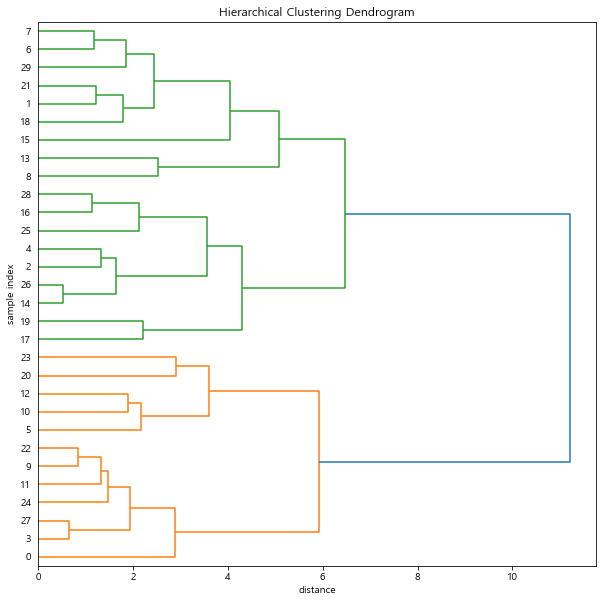

In [14]:
# 연결: ward, 거리 계산: Euclidean
Z_ward=linkage(df_raw_x, method="ward", metric="euclidean")
# 연결: average, 거리 계산: Euclidean
Z_average=linkage(df_raw_x, method="average", metric="euclidean")
# 연결: ward, 거리 계산: minkowski
Z_Minkowski=linkage(df_raw_x, method="average", metric="minkowski")

# 덴드로그램[연결:ward, 거리 계산: Euclidean]
plt.figure(figsize=(10,10))
ax=plt.subplot(111)

# DataFrame 변경:Z_ward, Z_average, Z_Minkowski
dendrogram(Z_ward, leaf_font_size=10, orientation="right")
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("distance")
plt.ylabel("sample index")


Text(0, 0.5, 'sample index')

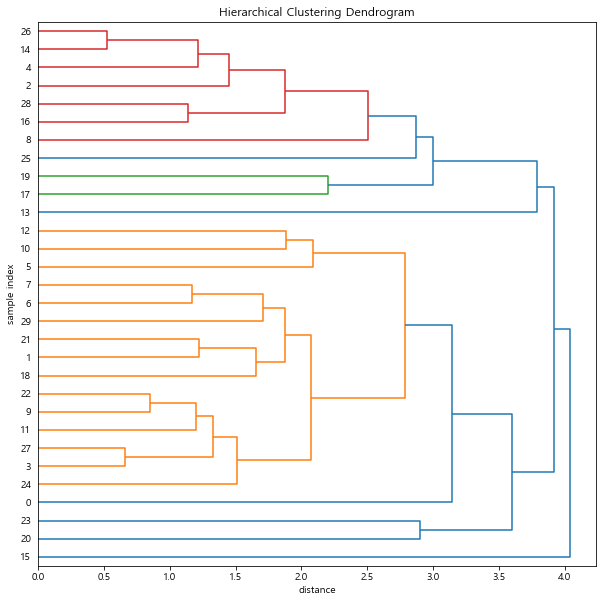

In [17]:
# 덴드로그램[연결:average, 거리 계산: Euclidean]
plt.figure(figsize=(10,10))
ax=plt.subplot(111)

dendrogram(Z_average, leaf_font_size=10, orientation="right")
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("distance")
plt.ylabel("sample index")

Text(0, 0.5, 'sample index')

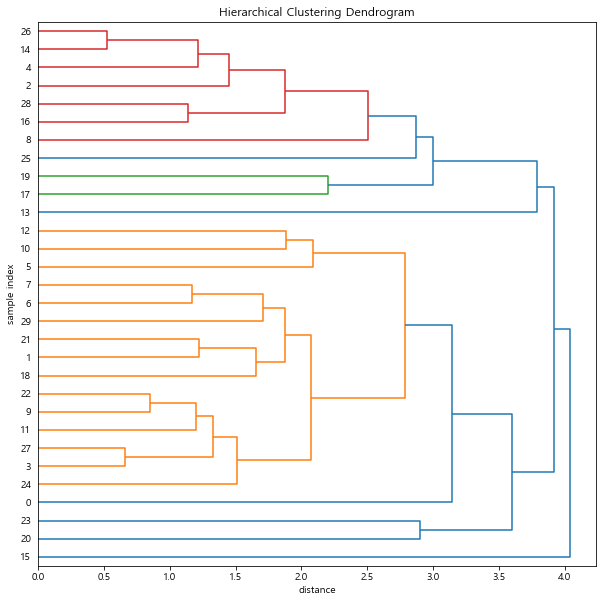

In [18]:
# 덴드로그램[연결:average, 거리 계산: Minkowski]
plt.figure(figsize=(10,10))
ax=plt.subplot(111)

dendrogram(Z_Minkowski, leaf_font_size=10, orientation="right")
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("distance")
plt.ylabel("sample index")

> 1번 ward 연결과 2, 3번의 average 연결은 다른 형태의 Dendrogram을 생성  

> 2번과 3번은 각각 Euclidean, Minkowski 거리 계산을 하였지만   
> 같은 Dendrogram을 생성

- 계층형 군집 생성

In [20]:
# linkage 함수를 통해 얻은 Z_ward 행렬 데이터를 이용하여 군집 생성
cluster_hierarchical=fcluster(Z=Z_ward, t=5, criterion="distance")
# 데이터에 계층형 군집 결과 입력
df_raw["ClusterHierarchical"]=cluster_hierarchical
df_raw.head()

,EVAL,DISSATIS,PRIVILEGE,CHANCE,ADVANCE,CRITISM,PROMOTION,ClusterHierarchical
0,43,51,30,39,61,92,45,1
1,63,64,51,54,63,73,47,5
2,71,70,68,69,76,86,48,3
3,61,63,45,47,54,84,35,1
4,81,78,56,66,71,83,47,3


In [21]:
# 군집별 데이터 요약
# 집계 함수를 이용한 군집별 데이터 요약
ds_summary_hc=df_raw.groupby("ClusterHierarchical").agg(["min", "mean", "max"])
# 집계 함수를 이용할 경우 열 이름이 두 줄에 걸쳐 나오므로 한 줄로 변환
level0=ds_summary_hc.columns.get_level_values(0)
level1=ds_summary_hc.columns.get_level_values(1)
ds_summary_hc.columns=level0+"_"+level1
ds_summary_hc.reset_index(inplace=True)
ds_summary_hc.round(3)

,ClusterHierarchical,EVAL_min,EVAL_mean,EVAL_max,DISSATIS_min,DISSATIS_mean,DISSATIS_max,PRIVILEGE_min,PRIVILEGE_mean,PRIVILEGE_max,...,CHANCE_max,ADVANCE_min,ADVANCE_mean,ADVANCE_max,CRITISM_min,CRITISM_mean,CRITISM_max,PROMOTION_min,PROMOTION_mean,PROMOTION_max
0,1,43,57.429,67,51,58.857,66,30,43.571,52,...,50,51,59.429,66,74,81.143,92,33,38.571,45
1,2,40,53.200,69,37,49.400,62,33,46.800,57,...,58,43,52.000,58,49,60.000,67,25,35.000,49
2,3,50,71.889,85,58,73.889,85,54,63.333,71,...,75,55,74.333,88,74,79.000,86,46,54.667,72
3,4,68,70.000,72,82,82.500,83,72,77.500,83,...,67,59,65.000,71,77,80.000,83,31,33.000,35
4,5,58,69.143,82,61,72.714,90,39,47.143,52,...,72,60,66.286,75,54,72.000,85,35,40.714,47


> 각 군집 별 변수 분포가 다름 (평균 등 통계량 확인)

- K-평균 군집분석

In [23]:
# 군집 개수 찾기: 각 데이터로부터 가장 가까운 군집 중심점까지의 거리 제곱합
# 최대 군집 생성 개수
n_iter_cluster=15
cluster_range=[i+1 for i in range(n_iter_cluster)]
clus_error=[]
for v_n_clus in cluster_range:
    clus=KMeans(v_n_clus)
    clus.fit(df_raw_x)
    # 각 데이터로부터 가장 가까운 군집 중심점까지 거리 제곱합
    clus_error.append(clus.inertia_)
ds_error=pd.DataFrame({"NumberofCluster":cluster_range, "Error":clus_error})
ds_error

,NumberofCluster,Error
0,1,180.000000
1,2,114.082503
2,3,93.636837
3,4,79.990206
4,5,65.847258
5,6,57.164383
6,7,50.953266
7,8,44.882302
8,9,39.292022
9,10,34.340629


> 군집 개수가 증가함에 따라 중심점까지의 거리는 가까워짐  
> ("Error"-거리 제곱을 뜻함)

Text(0, 0.5, 'Sum of squared distance')

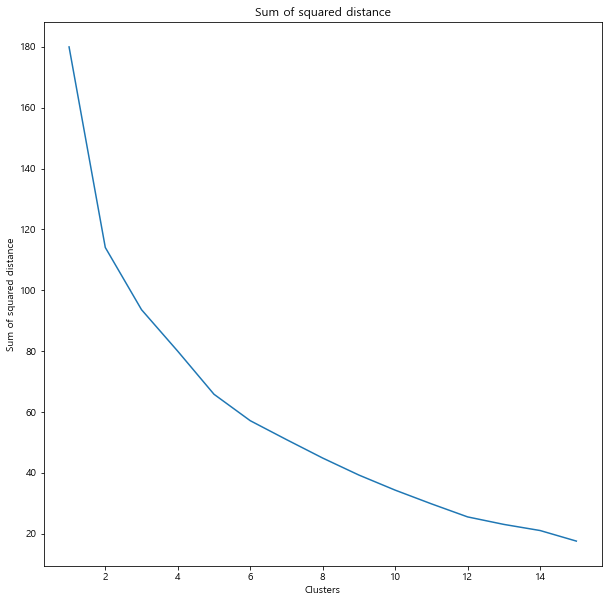

In [24]:
# 군집별 군집 중시점까지 거리 제곱합을 시각화
plt.figure(figsize=(10,10))
plt.plot(ds_error["NumberofCluster"], ds_error["Error"])
plt.title("Sum of squared distance")
plt.xlabel("Clusters")
plt.ylabel("Sum of squared distance")

In [25]:
# K-평균 군집 번호 생성
clus=KMeans(5)
clus.fit(df_raw_x)
cluster_kmeans=[i+1 for i in clus.labels_]
df_raw["ClusterKmeans"]=cluster_kmeans
df_raw.head()

,EVAL,DISSATIS,PRIVILEGE,CHANCE,ADVANCE,CRITISM,PROMOTION,ClusterHierarchical,ClusterKmeans
0,43,51,30,39,61,92,45,1,1
1,63,64,51,54,63,73,47,5,4
2,71,70,68,69,76,86,48,3,2
3,61,63,45,47,54,84,35,1,1
4,81,78,56,66,71,83,47,3,2


In [26]:
# K-평균 군집별 데이터 요약
ds_summary_km=df_raw.drop("ClusterHierarchical", axis=1, inplace=False).\
groupby("ClusterKmeans").agg(["min", "mean", "max"])
level0=ds_summary_km.columns.get_level_values(0)
level1=ds_summary_km.columns.get_level_values(1)
ds_summary_km.columns=level0+"_"+level1
ds_summary_km.reset_index(inplace=True)
ds_summary_km.round(3)

,ClusterKmeans,EVAL_min,EVAL_mean,EVAL_max,DISSATIS_min,DISSATIS_mean,DISSATIS_max,PRIVILEGE_min,PRIVILEGE_mean,PRIVILEGE_max,...,CHANCE_max,ADVANCE_min,ADVANCE_mean,ADVANCE_max,CRITISM_min,CRITISM_mean,CRITISM_max,PROMOTION_min,PROMOTION_mean,PROMOTION_max
0,1,43,57.429,67,51,58.857,66,30,43.571,52,...,50,51,59.429,66,74,81.143,92,33,38.571,45
1,2,66,75.500,85,70,78.625,85,54,63.625,72,...,74,71,77.625,88,74,79.500,86,31,51.375,72
2,3,40,53.200,69,37,49.400,62,33,46.800,57,...,58,43,52.000,58,49,60.000,67,25,35.000,49
3,4,58,69.143,82,61,72.714,90,39,47.143,52,...,72,60,66.286,75,54,72.000,85,35,40.714,47
4,5,50,61.000,68,58,67.000,83,65,72.000,83,...,75,55,59.333,64,77,78.333,80,35,49.000,60


> 각 군집 별 변수 분포가 다름 (평균 등 통계량 확인)

- DBSCAN 군집분석

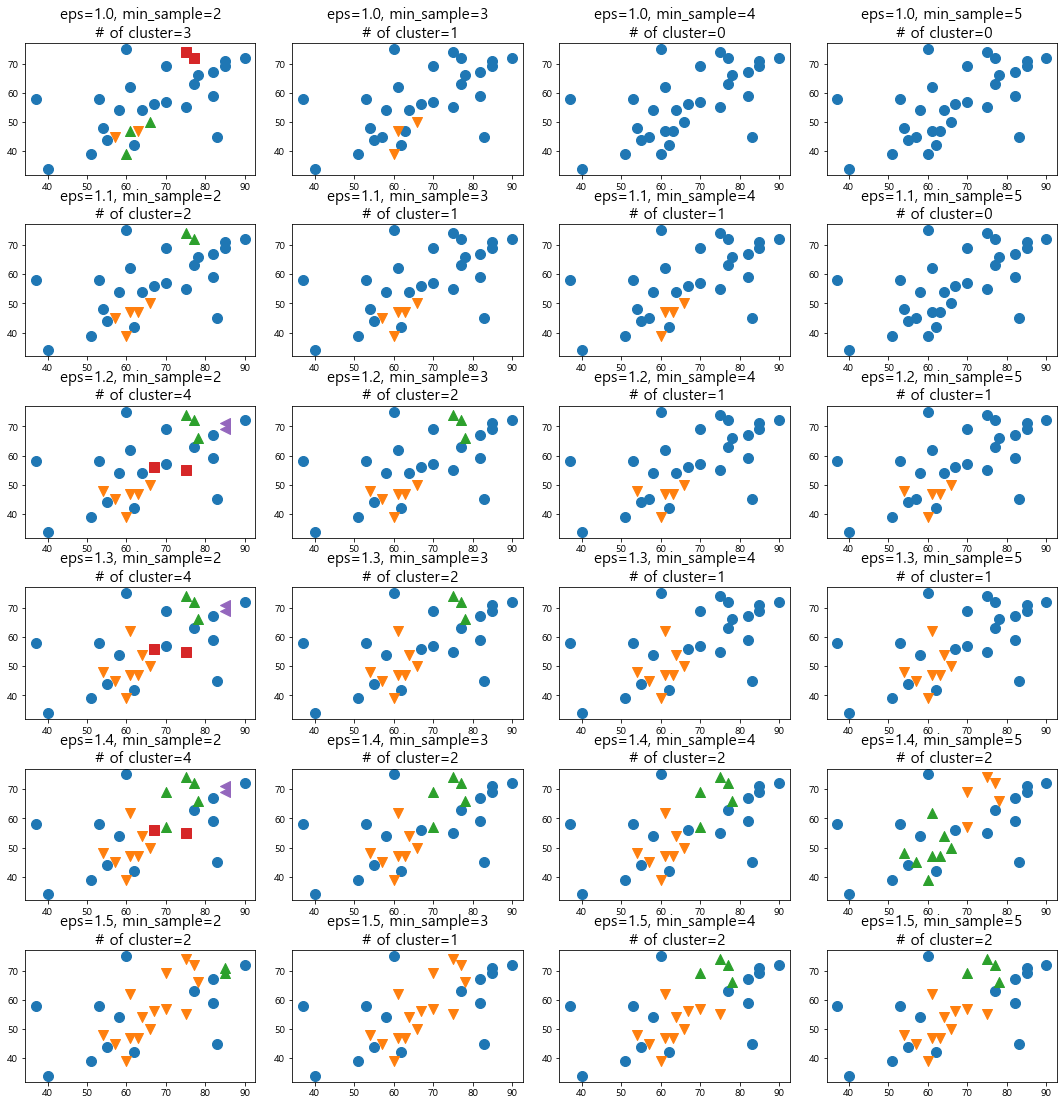

In [30]:
# X축: DISSATIS 변수, Y축: CHANCE
X=df_raw["DISSATIS"]
Y=df_raw["CHANCE"]
# 데이터 point 그림 종류
markers=["o", "v", "^", "s", "<", ">", "p", "D"]
# eps: 1.0~1.5, min_sample: 2~5
para_eps=[k/10 for k in range(10, 16, 1)]
para_min_sample=[2, 3, 4, 5]
fig, axes=plt.subplots(len(para_eps), len(para_min_sample), figsize=(15,15)) #plot 개수
fig.tight_layout(w_pad=1, h_pad=3) # plot간 간격
# enumerate(): 값의 index와 값을 순차적으로 반환
for i, eps in enumerate(para_eps):
    for j, min_sample in enumerate(para_min_sample):
        dbscan=DBSCAN(min_samples=min_sample, eps=eps) # dbscan 실행
        clusters=dbscan.fit_predict(df_raw_x) # 예측 분류
        clusters=clusters+1 # noise이 경우 -1로 표기되므로 1씩 더하여 0으로 변환
        for (n_clus, clus) in enumerate(range(min(clusters), max(clusters)+1, 1)): # 군집별 다른 그림 지정
            axes[i,j].scatter(X[clusters==clus], Y[clusters==clus], marker=markers[n_clus], s=100)
            axes[i,j].set_title("eps="+str(eps)+", min_sample="+str(min_sample)+\
                               "\n # of cluster="+str(max(clusters)), fontsize=15)

> p.261 참고

In [32]:
# eps: 특정 데이터로부터 다른 데이터를 포함하는 거리 min_samples: 군집이 되기 위한 최소 데이터 수
dbscan=DBSCAN(eps=1.4, min_samples=2).fit(df_raw_x)
# 군집 결과
cluster_dbscan= dbscan.labels_
# sklearn의 DBSCAN에서는 noise 데이터의 경우 군집이 -1로 표시되며 0번 군집부터 시작
# 다른 계층형, K-평균은 1번 군집부터 시작하므로 다른 군집 번호와 동일.
# Noise 데이터는 0번 군집으로 표기
for (i, val) in enumerate(cluster_dbscan):
    if val<0:
        cluster_dbscan[i]=0
    else:
        cluster_dbscan[i]=cluster_dbscan[i]+1
df_raw["ClusterDBScan"]=cluster_dbscan
df_raw.head()

,EVAL,DISSATIS,PRIVILEGE,CHANCE,ADVANCE,CRITISM,PROMOTION,ClusterHierarchical,ClusterKmeans,ClusterDBScan
0,43,51,30,39,61,92,45,1,1,0
1,63,64,51,54,63,73,47,5,4,1
2,71,70,68,69,76,86,48,3,2,2
3,61,63,45,47,54,84,35,1,1,1
4,81,78,56,66,71,83,47,3,2,2


In [34]:
# DB 스캔 군집별 요약 통계량
ds_summary_db=df_raw.drop(["ClusterHierarchical", "ClusterKmeans"], axis=1, inplace=False).\
groupby("ClusterDBScan").agg(["min", "mean", "max"])
level0=ds_summary_db.columns.get_level_values(0)
level1=ds_summary_db.columns.get_level_values(1)
ds_summary_db.columns=level0+"_"+level1
ds_summary_db.reset_index(inplace=True)
ds_summary_db.round(3)

,ClusterDBScan,EVAL_min,EVAL_mean,EVAL_max,DISSATIS_min,DISSATIS_mean,DISSATIS_max,PRIVILEGE_min,PRIVILEGE_mean,PRIVILEGE_max,...,CHANCE_max,ADVANCE_min,ADVANCE_mean,ADVANCE_max,CRITISM_min,CRITISM_mean,CRITISM_max,PROMOTION_min,PROMOTION_mean,PROMOTION_max
0,0,40,61.00,82,37,63.846,90,30,54.385,83,...,75,43,60.154,88,49,70.615,92,25,41.923,72
1,1,48,60.75,67,54,60.750,66,42,47.250,52,...,62,51,60.500,66,73,78.625,84,33,39.125,47
2,2,65,74.40,81,70,74.000,78,46,56.400,68,...,74,71,76.200,80,77,81.800,86,46,47.200,49
3,3,58,64.50,71,67,71.000,75,42,46.000,50,...,56,66,68.000,70,66,67.000,68,35,38.000,41
4,4,74,79.50,85,85,85.000,85,64,67.500,71,...,71,77,78.000,79,74,76.500,79,55,59.000,63


> 각 군집 별 변수 분포가 다름 (평균 등 통계량 확인)

# 연관규칙

장바구니 ID별 구매 항목 자료이다.  
장바구니 분석을 실시하고 결과를 해석하라.  
- 데이터: 직접 입력(변수: 2개, 자료: 15개)

## 1. 데이터 구성하기

In [39]:
df_raw=[["소주", "콜라", "맥주"],
       ["소주", "콜라", "와인"],
       ["소주", "주스"],
       ["콜라", "맥주"],
       ["소주", "콜라", "맥주", "와인"],
       ["주스"]]
df_raw

[['소주', '콜라', '맥주'],
 ['소주', '콜라', '와인'],
 ['소주', '주스'],
 ['콜라', '맥주'],
 ['소주', '콜라', '맥주', '와인'],
 ['주스']]

- 데이터 전처리

In [40]:
# Items 중 index 0번이 갖고 있으면 True, 아니면 False
enc= TransactionEncoder()
df_raw_enc=enc.fit_transform(X=df_raw)
# 위의 함수는 데이터를 행렬의 형태로 반환
# pandas의 DataFrame의 형태로 변환
df_asso=pd.DataFrame(df_raw_enc, columns=enc.columns_)
df_asso.head()

,맥주,소주,와인,주스,콜라
0,True,True,False,False,True
1,False,True,True,False,True
2,False,True,False,True,False
3,True,False,False,False,True
4,True,True,True,False,True


## 2. 라이브러리 불러오기

- 규칙 척도 임계값(지지도 50% 이상)

In [41]:
# 최소 지지도
v_min_sup=0.5

# 지지도 계싼
df_freq=apriori(df_asso, min_support=v_min_sup, use_colnames=True)
df_freq.round(3)

,support,itemsets
0,0.500,(맥주)
1,0.667,(소주)
2,0.667,(콜라)
3,0.500,"(콜라, 맥주)"
4,0.500,"(소주, 콜라)"


> 0 -> 맥주를 구매한 고객 : 0.5  

> 1 -> 소주를 구매한 고객 : 0.667  

> 3 -> 맥주와 콜라를 동시에 구매한 고객 : 0.5

- 지지도, 신뢰도, 향상도 산출

In [42]:
# 기준=신뢰도, 최소 신뢰도=0.5
df_asso_rule=association_rules(df_freq, metric="confidence", min_threshold=0.5)
df_asso_rule.round(3)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(콜라),(맥주),0.667,0.500,0.5,0.75,1.500,0.167,2.000
1,(맥주),(콜라),0.500,0.667,0.5,1.00,1.500,0.167,inf
2,(소주),(콜라),0.667,0.667,0.5,0.75,1.125,0.056,1.333
3,(콜라),(소주),0.667,0.667,0.5,0.75,1.125,0.056,1.333


> [(맥주), (콜라)] Confidence=1.0 : 맥주를 구매한 고객은 콜라도 반드시 구매  
> => 맥주를 구매한 고객에게 콜라를 추천  

> [(콜라), (맥주)] COnfidence=0.75 :   
> 콜라를 구매한 고객 중 맥주를 고른 고객은 0.75   

> [(콜라), (소주)] Lift=1.125 / [(콜라), (맥주)] Lift=1.5 :   
> 콜라를 구매한 고객들에게는 소주보다 맥주를 추천